In [53]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17,6)});
sns.set(style='whitegrid')

# Импорт библиотек

In [279]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(rc={'figure.figsize':(17,6)})
sns.set(style='whitegrid');

# Загрузка данных

In [2]:
df = pd.read_csv('hour_online.csv', index_col=['Time'], parse_dates=['Time'])

print(df.shape)
df.head(3)

(2625, 1)


,Users
Time,
2017-01-01 00:00:00,34002
2017-01-01 01:00:00,37947
2017-01-01 02:00:00,41517


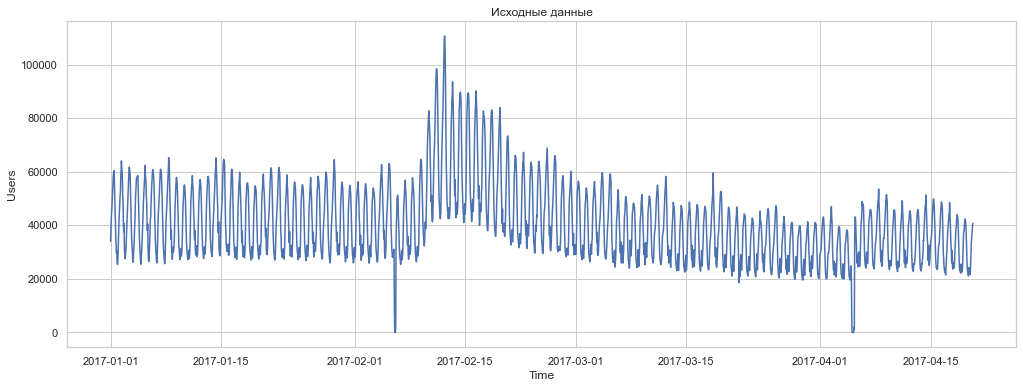

In [93]:
sns.lineplot(x=df.index, y='Users', data=df);
#plt.xticks(rotation=45)
plt.title('Исходные данные');

# Скользящая средняя

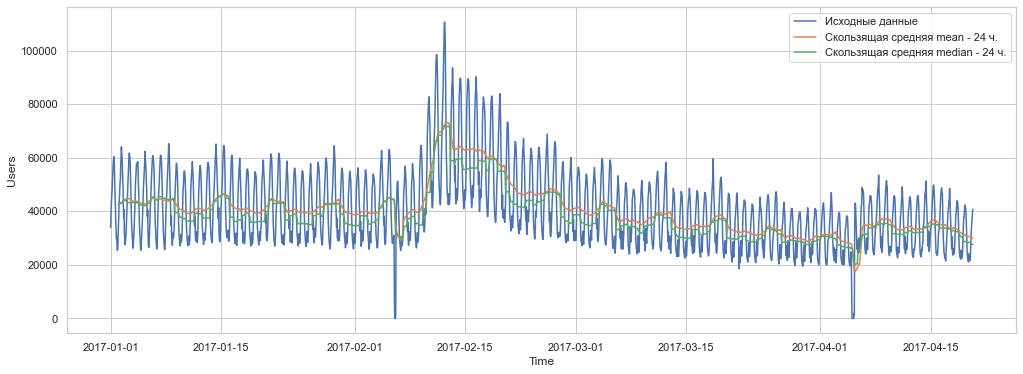

In [94]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).mean(), label='Скользящая средняя mean - 24 ч.');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24).median(), label='Скользящая средняя median - 24 ч.');

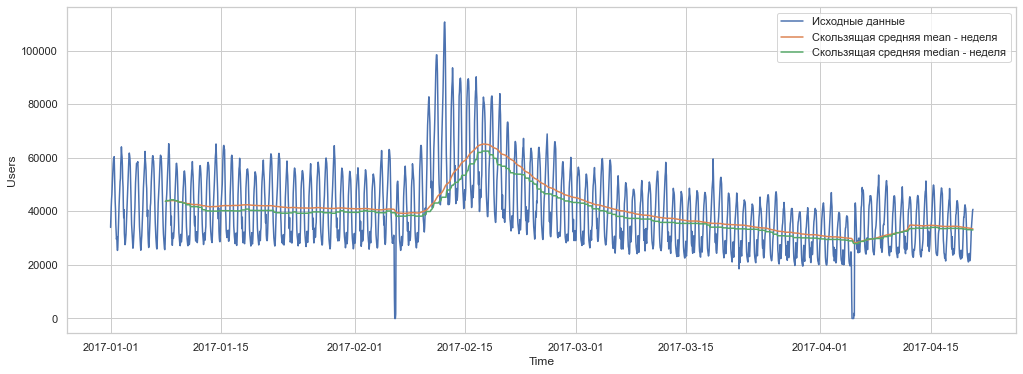

In [95]:
sns.lineplot(x=df.index, y='Users', data=df, label='Исходные данные');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).mean(), label='Скользящая средняя mean - неделя');
sns.lineplot(x=df.index, y='Users', data=df.rolling(window=24*7).median(), label='Скользящая средняя median - неделя');

# Взвешенная средняя

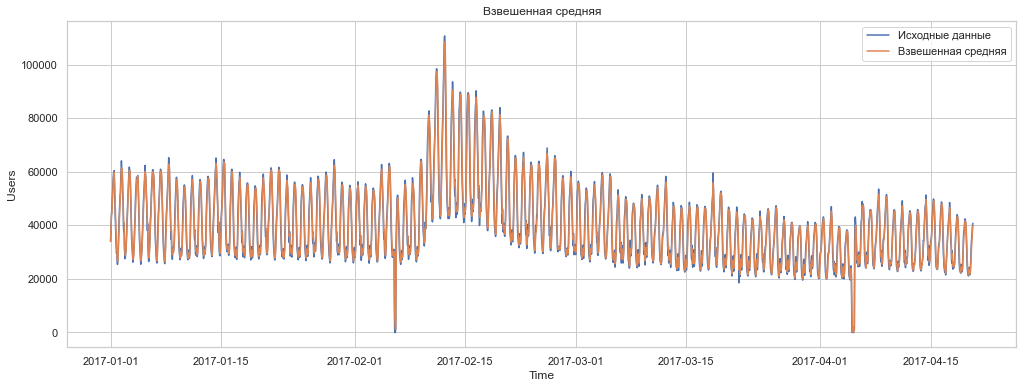

In [96]:
def weighted_average(series, weights):
    w = len(weights)
    result = list(series[0:w-1]) # Первые значения оставляем как есть

    for n in range(0, len(series)-w+1):
        b = series[n:n+w]
        result.append(sum(b * weights))
    return result

sns.lineplot(x=df.index, y=df.Users, label='Исходные данные')
sns.lineplot(x=df.index, y=weighted_average(df.Users, [0.03,0.07,0.1,0.2,0.6]), label='Взвешенная средняя')

plt.title('Взвешенная средняя');

# Экспоненциальное сглаживание

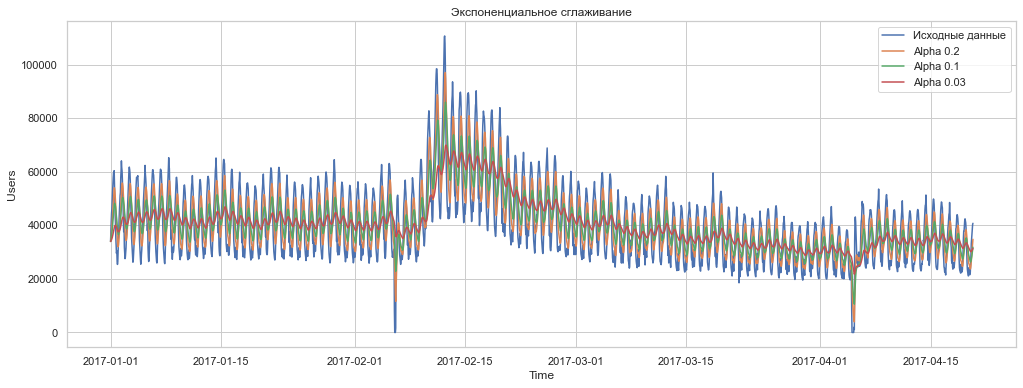

In [97]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # Первое значение оставляем как есть
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

sns.lineplot(x=df.index, y=df.Users, label='Исходные данные')

for alpha in [0.2, 0.1, 0.03]:
    sns.lineplot(x=df.index, y=exponential_smoothing(df.Users, alpha), label=f'Alpha {alpha}')

plt.title('Экспоненциальное сглаживание');

# Двойное экспоненциальное сглаживание

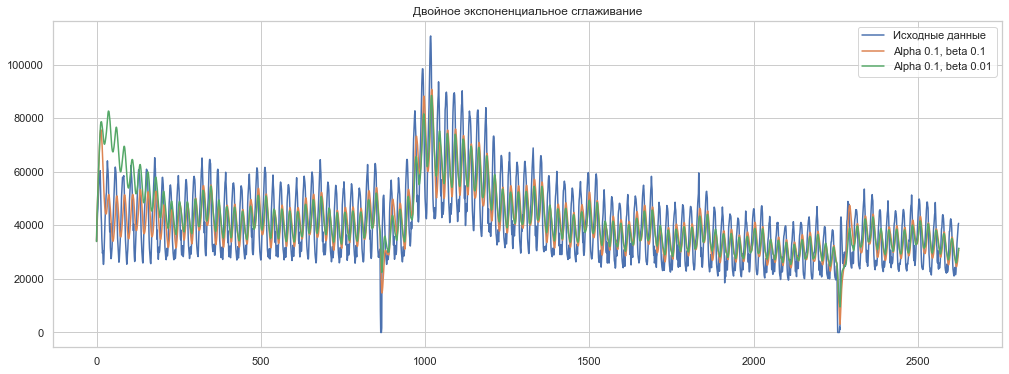

In [176]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level = series[0]
            trend = series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        
        last_level = level
        level = alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        
    return result

plt.plot(df.Users.values, label = 'Исходные данные')

for alpha in [0.9, 0.02]:
    for beta in [0.9, 0.02]:
        plt.plot(double_exponential_smoothing(df.Users, alpha, beta), 
                 label=f'Alpha {alpha}, beta {beta}')
        
plt.title('Двойное экспоненциальное сглаживание');
plt.legend(loc='best');

# Тройное экспоненциальное сглаживание

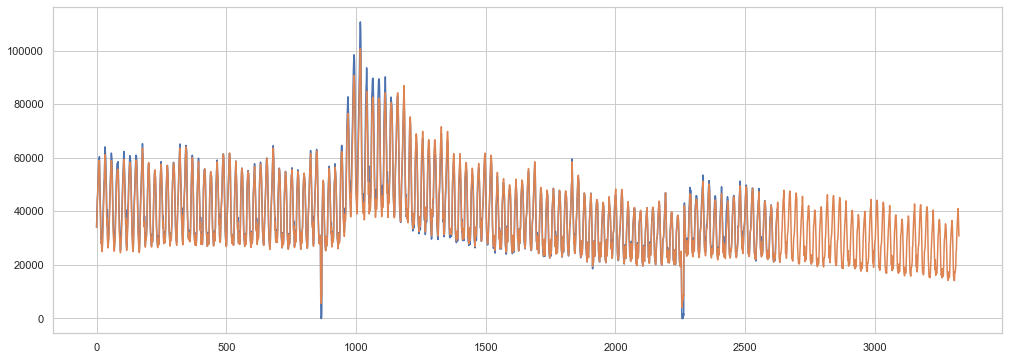

In [273]:
z = HoltWinters(df.Users, 24*7, 0.000001, 0.0001, 0.8, 700, 2)
z.initial_trend()
z.initial_seasonal_components()
z.triple_exponential_smoothing()

plt.plot(df.Users.values, label = 'Исходные данные')
plt.plot(z.result, label = 'Тройное сглаживание');

In [274]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [317]:
data = df.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0.1, 0.1, 0.1] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.015594032793596058 0.06515502505812237 0.06143152540102381


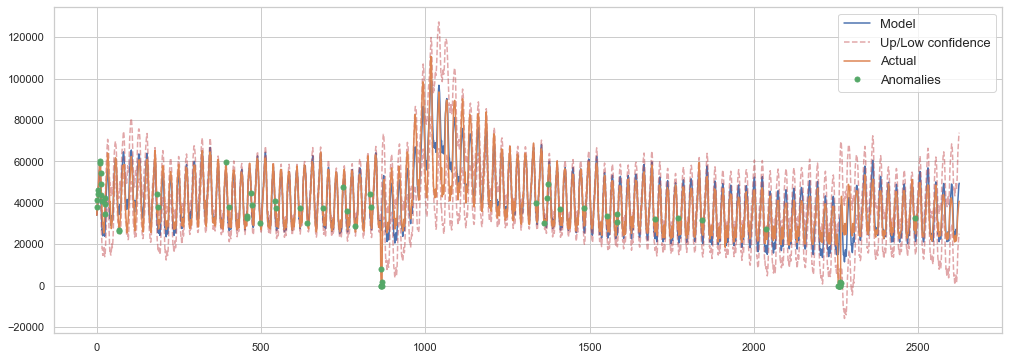

In [318]:
data = df.Users
model = HoltWinters(
    data[:-128], 
    slen = 24*7, 
    alpha = alpha_final, 
    beta = beta_final, 
    gamma = gamma_final, 
    n_preds = 128, 
    scaling_factor = 2.56)
model.triple_exponential_smoothing()

def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values < model.LowerBond] = data.values[data.values < model.LowerBond]
    Anomalies[data.values > model.UpperBond] = data.values[data.values > model.UpperBond]

    plt.plot(model.result, label = "Model")
    
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    
    #plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    
    plt.plot(Anomalies, "o", markersize=5, label = "Anomalies")
    #plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    #plt.grid(True)
    #plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

plotHoltWinters()